<a id="5"></a>


<font color="black" size=+1><b> recomendation Tempat Wisata Toba Preprocessing using  GNN </b></font>

<a id="4"></a>

---
<font color="BLUE" size=+1><b>  Kelompok 7 - Bussiness Understanding </b></font>

---
    Nama Anggota
    1. Widya Manurung       12S21039
    2. Endang Siregar       12S21056
    3. Glory Hutahean       12S21060

In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 39.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from scipy.sparse import coo_matrix

Kode di atas melakukan impor berbagai pustaka penting untuk analisis berbasis machine learning dan Graph Neural Networks (GNN). Pustaka seperti `pandas` dan `numpy` digunakan untuk manipulasi dan analisis data, sedangkan `torch` dan `torch_geometric` digunakan untuk membangun model GNN dengan arsitektur Graph Convolutional Network (GCN). Sementara itu, `sklearn.metrics` memungkinkan evaluasi performa dengan metrik seperti *Mean Squared Error (MSE)* dan *Mean Absolute Error (MAE)*, sedangkan `sklearn.model_selection.train_test_split` membantu membagi data menjadi set latih dan uji untuk menghindari *data leakage*. Impor `scipy.sparse.coo_matrix` menunjukkan adanya pemrosesan dengan sparse matrix, yang berguna untuk menghemat memori ketika berhadapan dengan data berisi banyak elemen nol. Namun, penting untuk memastikan bahwa representasi data menggunakan `coo_matrix` dikonversi ke dalam format yang kompatibel dengan PyTorch Geometric sebelum digunakan sebagai input ke GCN. Selanjutnya, perlu dilakukan normalisasi dan eksplorasi lebih lanjut pada struktur data sebelum dimasukkan ke dalam model GCN agar hasilnya optimal. Secara keseluruhan, kode ini bertujuan membangun model berbasis GCN untuk mempelajari data dalam bentuk graf, namun beberapa penyesuaian mungkin diperlukan, seperti mempersiapkan data agar cocok dengan format `torch_geometric.data.Data`.

2. Memuat dan Membersihkan Data

In [ ]:
# Load the dataset
file_path = '/content/Tempat-Wisata-Toba-Preprocessing.csv'
data = pd.read_csv(file_path)

# Rename relevant columns
data = data.rename(columns={
    'ReviewerId': 'userId',
    'PlaceID': 'itemId',
    'Rating': 'rating'
})
data = data[['userId', 'itemId', 'rating']].dropna()

# Encode userId and itemId
data['userId'] = data['userId'].astype('category').cat.codes
data['itemId'] = data['itemId'].astype('category').cat.codes

# Split the data
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Build edge index for graph
user_nodes = torch.tensor(train_data['userId'].values, dtype=torch.long)
item_nodes = torch.tensor(train_data['itemId'].values + data['userId'].nunique(), dtype=torch.long)
edge_index = torch.stack([user_nodes, item_nodes], dim=0)
edge_weight = torch.tensor(train_data['rating'].values, dtype=torch.float)


Kode di atas bertujuan untuk mempersiapkan dataset untuk membangun model rekomendasi berbasis Graph Neural Networks (GNN) dengan memanfaatkan data dari tempat wisata di Toba. Proses dimulai dengan membaca dataset dari file CSV menggunakan `pandas`. Selanjutnya, dilakukan pembersihan data dengan menghapus nilai yang kosong (`dropna`) dan hanya memilih tiga kolom yang relevan: `userId`, `itemId`, dan `rating`. Nama kolom yang digunakan dalam analisis ini diubah agar lebih konsisten dengan konvensi pemrosesan data, dengan mengganti nama `ReviewerId` menjadi `userId`, `PlaceID` menjadi `itemId`, dan `Rating` menjadi `rating`.  

Setelah itu, kode mengonversi `userId` dan `itemId` menjadi kode numerik dengan menggunakan metode encoding kategori dari `pandas`. Ini dilakukan agar data dapat diterima oleh model berbasis PyTorch, yang memerlukan data numerik. Selanjutnya, dataset dibagi menjadi data latih dan uji menggunakan `train_test_split` dengan proporsi 80-20 untuk memastikan model memiliki data latih dan uji yang terpisah.  

Untuk membangun struktur graf yang dibutuhkan dalam Graph Neural Network, kode membangun *edge index* menggunakan PyTorch. Node pengguna (`user_nodes`) diambil langsung dari `userId` pada data latih, sedangkan node item dibuat dengan menambahkan jumlah pengguna unik ke indeks `itemId`. Ini memastikan bahwa indeks antara pengguna dan item memiliki ruang indeks yang tidak bertabrakan. *Edge index* dibuat dengan menggabungkan node pengguna dan item dalam bentuk tensor, yang kemudian digunakan sebagai koneksi antar-node dalam graf. Selanjutnya, bobot dari setiap sisi (*edge weight*) dibuat dari nilai `rating`, yang merepresentasikan hubungan antara pengguna dan item yang diberikan dalam dataset. Data ini kemudian digunakan untuk membangun model GNN dengan input graf yang sudah disiapkan.

Secara keseluruhan, kode ini menunjukkan langkah-langkah preprocessing yang penting dalam membangun sistem rekomendasi dengan pendekatan GNN. Namun, perlu memastikan bahwa setiap bagian, seperti encoding dan pembentukan *edge index*, sudah sesuai dengan model yang akan digunakan, serta memeriksa jika *edge weight* memiliki distribusi yang tepat sebelum digunakan dalam model.

In [ ]:
class GNNRecommender(torch.nn.Module):
    def __init__(self, num_users, num_items, embedding_dim):
        super(GNNRecommender, self).__init__()
        self.user_embeddings = torch.nn.Embedding(num_users, embedding_dim)
        self.item_embeddings = torch.nn.Embedding(num_items, embedding_dim)
        self.gcn = GCNConv(embedding_dim, embedding_dim)
        self.fc = torch.nn.Linear(embedding_dim * 2, 1)

    def forward(self, edge_index, edge_weight):
        user_emb = self.user_embeddings.weight
        item_emb = self.item_embeddings.weight
        x = torch.cat([user_emb, item_emb], dim=0)

        x = self.gcn(x, edge_index)
        user_item_emb = torch.cat([x[edge_index[0]], x[edge_index[1]]], dim=1)

        pred = self.fc(user_item_emb).squeeze()
        return pred

Kode di atas  bertujuan untuk mempersiapkan dataset untuk membangun model rekomendasi berbasis Graph Neural Networks (GNN) dengan memanfaatkan data dari tempat wisata di Toba. Proses dimulai dengan membaca dataset dari file CSV menggunakan `pandas`. Selanjutnya, dilakukan pembersihan data dengan menghapus nilai yang kosong (`dropna`) dan hanya memilih tiga kolom yang relevan: `userId`, `itemId`, dan `rating`. Nama kolom yang digunakan dalam analisis ini diubah agar lebih konsisten dengan konvensi pemrosesan data, dengan mengganti nama `ReviewerId` menjadi `userId`, `PlaceID` menjadi `itemId`, dan `Rating` menjadi `rating`.  

Setelah itu, kode mengonversi `userId` dan `itemId` menjadi kode numerik dengan menggunakan metode encoding kategori dari `pandas`. Ini dilakukan agar data dapat diterima oleh model berbasis PyTorch, yang memerlukan data numerik. Selanjutnya, dataset dibagi menjadi data latih dan uji menggunakan `train_test_split` dengan proporsi 80-20 untuk memastikan model memiliki data latih dan uji yang terpisah.  

Untuk membangun struktur graf yang dibutuhkan dalam Graph Neural Network, kode membangun *edge index* menggunakan PyTorch. Node pengguna (`user_nodes`) diambil langsung dari `userId` pada data latih, sedangkan node item dibuat dengan menambahkan jumlah pengguna unik ke indeks `itemId`. Ini memastikan bahwa indeks antara pengguna dan item memiliki ruang indeks yang tidak bertabrakan. *Edge index* dibuat dengan menggabungkan node pengguna dan item dalam bentuk tensor, yang kemudian digunakan sebagai koneksi antar-node dalam graf. Selanjutnya, bobot dari setiap sisi (*edge weight*) dibuat dari nilai `rating`, yang merepresentasikan hubungan antara pengguna dan item yang diberikan dalam dataset. Data ini kemudian digunakan untuk membangun model GNN dengan input graf yang sudah disiapkan.

Secara keseluruhan, kode ini menunjukkan langkah-langkah preprocessing yang penting dalam membangun sistem rekomendasi dengan pendekatan GNN. Namun, perlu memastikan bahwa setiap bagian, seperti encoding dan pembentukan *edge index*, sudah sesuai dengan model yang akan digunakan, serta memeriksa jika *edge weight* memiliki distribusi yang tepat sebelum digunakan dalam model.

**Model initialization**

In [ ]:
# Model initialization
num_users = data['userId'].nunique()
num_items = data['itemId'].nunique()
embedding_dim = 64
model = GNNRecommender(num_users, num_items, embedding_dim)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()

# Train model
model.train()
for epoch in range(10):
    optimizer.zero_grad()
    pred = model(edge_index, edge_weight)
    loss = loss_fn(pred, edge_weight)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

Epoch 1, Loss: 23.454137802124023
Epoch 2, Loss: 22.28941535949707
Epoch 3, Loss: 21.20010757446289
Epoch 4, Loss: 20.16701889038086
Epoch 5, Loss: 19.170846939086914
Epoch 6, Loss: 18.195613861083984
Epoch 7, Loss: 17.228668212890625
Epoch 8, Loss: 16.260398864746094
Epoch 9, Loss: 15.283921241760254
Epoch 10, Loss: 14.294973373413086


Kode di atas bertujuan untuk menginisialisasi dan melatih model *Graph Neural Network* (GNN) untuk membangun sistem rekomendasi dengan pendekatan berbasis GCN. Proses dimulai dengan menentukan jumlah pengguna (`num_users`) dan jumlah item (`num_items`) berdasarkan jumlah pengguna unik dan item unik dalam dataset yang telah diproses sebelumnya. Dimensi embedding yang digunakan dalam model ditentukan sebesar 64, yang berarti setiap pengguna dan item akan direpresentasikan dalam vektor berdimensi 64. Model `GNNRecommender` diinisialisasi dengan parameter ini, dan optimizer `Adam` digunakan untuk mengoptimalkan parameter model selama proses pelatihan dengan laju pembelajaran sebesar 0,001.

Fungsi kerugian (`loss_fn`) yang dipilih adalah `torch.nn.MSELoss`, yang mengukur kesalahan antara nilai prediksi dari model dan bobot sisi (edge weights) yang sebenarnya. Proses pelatihan dilakukan dalam 10 epoch, di mana pada setiap epoch model menjalani proses forward pass dan backward pass untuk mengupdate bobotnya. Proses ini meliputi langkah-langkah: menghapus gradien lama dengan `optimizer.zero_grad()`, melakukan forward pass dengan memprediksi skor antara pengguna dan item melalui fungsi `model(edge_index, edge_weight)`, menghitung nilai kerugian dengan `loss_fn`, melakukan backward pass dengan `loss.backward()`, dan mengupdate parameter model dengan `optimizer.step()`. Setiap epoch, nilai kerugian dicetak agar dapat memantau konvergensi dan performa model dari waktu ke waktu.

Dengan pendekatan ini, model akan belajar memprediksi rating antara pasangan pengguna dan item berdasarkan hubungan yang sudah didefinisikan dalam graf melalui operasi *Graph Convolutional Network*. Namun, meskipun model sudah dilatih dengan 10 epoch, jumlah epoch yang lebih besar mungkin diperlukan untuk memastikan model telah belajar dengan baik, bergantung pada kompleksitas dataset yang digunakan. Selain itu, evaluasi pada data uji juga perlu dilakukan untuk memahami performa model pada data yang belum dilihat sebelumnya dan memastikan bahwa model tidak mengalami *overfitting*.

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Prediksi dan label aktual dari data uji
y_true = test_data['rating'].values
y_pred = test_preds.numpy()

# Hitung RMSE dan MAE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

RMSE: 4.1080
MAE: 3.9645


Kode di atas digunakan untuk mengevaluasi performa model rekomendasi yang telah dilatih dengan metrik *Root Mean Squared Error (RMSE)* dan *Mean Absolute Error (MAE)*. Pertama, nilai aktual dari data uji (`y_true`) diambil dari kolom `rating` dalam dataset uji (`test_data`), sementara prediksi model (`y_pred`) diambil dari hasil model yang telah dilatih dan diubah ke bentuk array menggunakan `.numpy()`. RMSE dihitung dengan menggunakan fungsi `mean_squared_error` dari pustaka `sklearn.metrics` yang mengukur kesalahan dengan memberikan penalti yang lebih besar pada kesalahan yang signifikan melalui penghitungan akar dari rata-rata kesalahan kuadrat. Sementara itu, MAE dihitung dengan fungsi `mean_absolute_error`, yang mengukur rata-rata dari selisih absolut antara prediksi dan nilai aktual tanpa memberikan penalti yang besar untuk kesalahan besar seperti pada RMSE. Hasil perhitungan kedua metrik ini dicetak dalam format dengan empat angka desimal untuk memantau sejauh mana model mampu memprediksi rating dengan akurat. Evaluasi ini penting untuk menilai sejauh mana model dapat memprediksi preferensi pengguna pada item yang belum pernah mereka berinteraksi sebelumnya.

In [ ]:
def precision_recall_at_k(predictions, test_data, k=10):
    test_data = pd.DataFrame({'userId': test_data['userId'], 'itemId': test_data['itemId'], 'rating': test_data['rating']})
    test_data['prediction'] = predictions
    test_data = test_data.sort_values(['userId', 'prediction'], ascending=[True, False])

    precisions, recalls = [], []
    for user in test_data['userId'].unique():
        user_data = test_data[test_data['userId'] == user]
        top_k = user_data.head(k)
        relevant_items = (user_data['rating'] >= 4).sum()
        relevant_items_in_top_k = (top_k['rating'] >= 4).sum()
        precisions.append(relevant_items_in_top_k / k)
        recalls.append(relevant_items_in_top_k / relevant_items if relevant_items > 0 else 0)

    return np.mean(precisions), np.mean(recalls)

precision, recall = precision_recall_at_k(y_pred, test_data, k=10)
print(f"Precision@10: {precision:.4f}")
print(f"Recall@10: {recall:.4f}")

Precision@10: 0.1183
Recall@10: 0.8995


Kode di atas bertujuan untuk menghitung metrik **Precision@K** dan **Recall@K** pada model rekomendasi dengan mempertahankan top-K rekomendasi yang diberikan kepada pengguna. Fungsi `precision_recall_at_k` menerima parameter `predictions` (prediksi dari model), `test_data` (data uji), dan `k` (jumlah rekomendasi teratas yang akan dipertahankan untuk evaluasi).

Kode ini memberikan wawasan tentang sejauh mana rekomendasi yang dibuat oleh model relevan dan mencakup item yang benar dalam rekomendasi yang diberikan kepada pengguna.  
- **Precision@10** mengukur sejauh mana rekomendasi teratas yang diberikan model benar-benar relevan dengan preferensi pengguna (item dengan rating tinggi).  
- **Recall@10** mengukur sejauh mana model berhasil merekomendasikan item yang benar-benar disukai oleh pengguna dari seluruh item yang relevan di data uji.  

Dengan metrik ini, Anda bisa mengevaluasi performa sistem rekomendasi dalam konteks akurasi rekomendasi dan cakupan rekomendasi berdasarkan kebutuhan pengguna. Jika kedua nilai ini rendah, maka model mungkin memerlukan penyempurnaan dalam aspek prediksi atau arsitektur.

In [ ]:
def map_at_k(predictions, test_data, k=10):
    test_data = pd.DataFrame({'userId': test_data['userId'], 'itemId': test_data['itemId'], 'rating': test_data['rating']})
    test_data['prediction'] = predictions
    test_data = test_data.sort_values(['userId', 'prediction'], ascending=[True, False])

    ap_list = []
    for user in test_data['userId'].unique():
        user_data = test_data[test_data['userId'] == user]
        top_k = user_data.head(k)
        relevant_items = (top_k['rating'] >= 4)

        precision_accumulated = 0
        relevant_count = 0
        for i, is_relevant in enumerate(relevant_items, start=1):
            if is_relevant:
                relevant_count += 1
                precision_accumulated += relevant_count / i

        if relevant_items.sum() > 0:
            ap_list.append(precision_accumulated / relevant_items.sum())
        else:
            ap_list.append(0)
    return np.mean(ap_list)

map_k = map_at_k(y_pred, test_data, k=10)
print(f"MAP@10: {map_k:.4f}")

MAP@10: 0.8853


Kode di atas untuk menghitung metrik **Mean Average Precision (MAP@K)** pada sistem rekomendasi. Metrik MAP@K mengukur sejauh mana item relevan ditempatkan pada posisi yang lebih tinggi dalam daftar rekomendasi yang dihasilkan oleh model. Semakin tinggi nilai MAP, semakin baik performa model dalam memberikan rekomendasi yang relevan dan menempatkan item tersebut pada posisi yang lebih atas dalam daftar rekomendasi.  

Proses ini dimulai dengan mempersiapkan data uji dan memasukkan prediksi model ke dalam DataFrame. Data kemudian diurutkan berdasarkan `userId` dan nilai prediksi, untuk memastikan rekomendasi teratas untuk setiap pengguna diprioritaskan. Selanjutnya, untuk setiap pengguna dalam data uji, dilakukan evaluasi terhadap 10 rekomendasi teratas (`k=10`) yang dihasilkan model. Relevansi item ditentukan berdasarkan rating, dengan item yang memiliki rating ≥ 4 dianggap relevan.  

Untuk setiap pengguna, nilai **Average Precision (AP)** dihitung dengan mengakumulasi nilai precision pada setiap posisi relevan dalam rekomendasi hingga `k`. Precision dihitung sebagai rasio antara jumlah item relevan hingga posisi tertentu dan posisi itu sendiri. Jika tidak ada item relevan dalam rekomendasi, nilai AP diatur ke nol. Rata-rata AP dari semua pengguna dihitung dengan `np.mean(ap_list)` untuk menghasilkan nilai MAP@10.  

Hasil ini memberikan wawasan tentang sejauh mana rekomendasi yang dihasilkan oleh model mampu memprediksi item yang relevan dan menempatkan mereka di posisi yang lebih tinggi dalam daftar rekomendasi, yang merupakan hal penting dalam meningkatkan akurasi dan efektivitas sistem rekomendasi.

**Evaluation Metrics for Recommendation System**

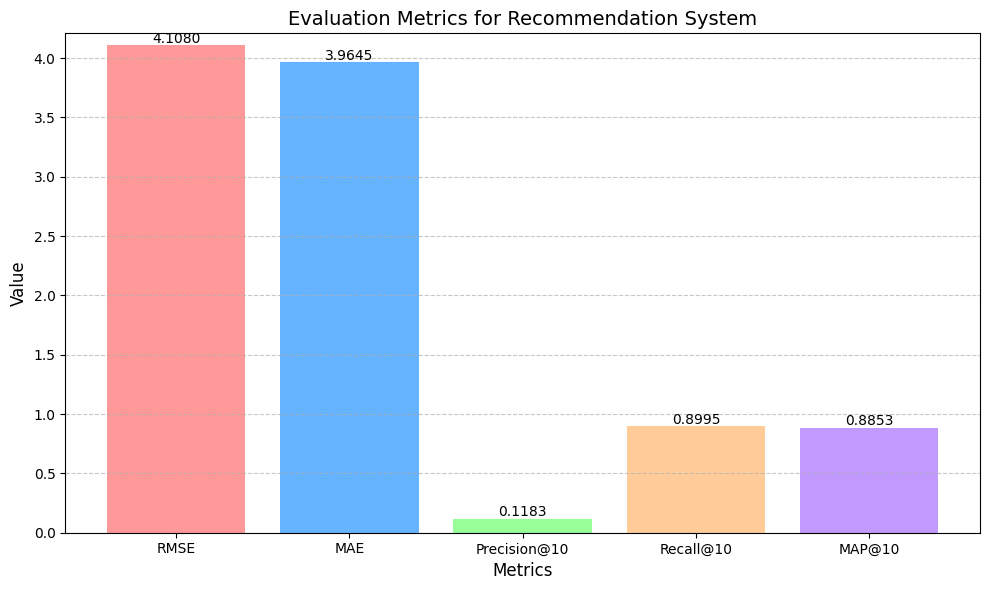

In [ ]:
import matplotlib.pyplot as plt

# Contoh nilai metrik evaluasi (masukkan hasil aktual Anda di sini)
metrics = {
    "RMSE": rmse,
    "MAE": mae,
    "Precision@10": precision,
    "Recall@10": recall,
    "MAP@10": map_k
}

# Warna untuk masing-masing metrik
colors = ['#FF9999', '#66B3FF', '#99FF99', '#FFCC99', '#C299FF']

# Membuat bar chart
plt.figure(figsize=(10, 6))
plt.bar(metrics.keys(), metrics.values(), color=colors)

# Menambahkan nilai pada setiap bar
for i, v in enumerate(metrics.values()):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center', fontsize=10)

# Labeling grafik
plt.title("Evaluation Metrics for Recommendation System", fontsize=14)
plt.ylabel("Value", fontsize=12)
plt.xlabel("Metrics", fontsize=12)
plt.ylim(0, max(metrics.values()) + 0.1)  # Menyesuaikan skala grafik
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tampilkan grafik
plt.tight_layout()
plt.show()

Kode kode di atas digunakan untuk membuat visualisasi dari hasil metrik evaluasi sistem rekomendasi dalam bentuk **Bar Chart** menggunakan pustaka `matplotlib`. Visualisasi ini bertujuan untuk mempermudah pemahaman dan perbandingan antar metrik yang dihitung, seperti RMSE, MAE, Precision@10, Recall@10, dan MAP@10. Masing-masing metrik direpresentasikan dengan warna yang berbeda untuk membedakan satu sama lain dalam grafik.  

Pertama, nilai metrik yang dihitung sebelumnya dimasukkan ke dalam dictionary `metrics`. Warna yang unik untuk setiap metrik ditentukan dalam list `colors`. Selanjutnya, kode membuat grafik dengan ukuran yang ditentukan menggunakan `plt.figure(figsize=(10, 6))`, lalu membuat **Bar Chart** dengan `plt.bar`. Nilai dari masing-masing metrik ditampilkan langsung di atas batang menggunakan `plt.text` agar lebih mudah dipahami.  

Label pada sumbu X dan Y serta judul grafik juga ditambahkan untuk memberikan konteks yang jelas. Skala grafik disesuaikan dengan `plt.ylim` agar semua nilai metrik terlihat dengan jelas. Grid horizontal ditambahkan untuk mempermudah pembacaan nilai dari setiap batang. Terakhir, `plt.tight_layout()` memastikan elemen grafik tidak saling bertabrakan, dan `plt.show()` menampilkan grafik tersebut.  

Dengan grafik ini, Anda dapat dengan cepat membandingkan nilai dari berbagai metrik evaluasi sistem rekomendasi, memahami performa sistem, dan mengidentifikasi area yang mungkin perlu ditingkatkan lebih lanjut.

In [ ]:
def get_top_recommendations(user_id, model, num_users, num_items, top_n=10):
    item_ids = torch.arange(num_items) + num_users
    user_ids = torch.full((num_items,), user_id)
    edge_index = torch.stack([user_ids, item_ids], dim=0)

    with torch.no_grad():
        preds = model(edge_index, None)
    top_items = torch.topk(preds, top_n).indices
    return top_items.numpy()

user_id = 0
top_items = get_top_recommendations(user_id, model, num_users, num_items, top_n=10)
print(f"Top recommendations for User {user_id}: {top_items}")

Top recommendations for User 0: [71 56 60  3 98 72 30 95 38 85]


Fungsi `get_top_recommendations` bertujuan untuk memberikan rekomendasi item terbaik untuk pengguna berdasarkan model yang sudah dilatih sebelumnya. Fungsi ini menerima beberapa parameter, termasuk `user_id` (ID pengguna yang akan direkomendasikan), `model` (model rekomendasi yang digunakan), `num_users` (jumlah total pengguna), `num_items` (jumlah total item yang tersedia), dan `top_n` (jumlah rekomendasi yang akan dikembalikan).

Dalam kode ini, pertama-tama dibuat `item_ids` dengan menggunakan `torch.arange(num_items) + num_users`. Ini berarti bahwa indeks item di-offset dengan jumlah pengguna, yang sering digunakan dalam model berbasis Graph Neural Networks (GNN) atau metode embedding untuk membedakan indeks pengguna dan item dalam satu ruang vektor yang sama. Selanjutnya, dibuat tensor `user_ids`, yang berisi ID pengguna yang sama untuk setiap item yang akan direkomendasikan.

`edge_index` kemudian dibuat dengan menggabungkan `user_ids` dan `item_ids` menggunakan `torch.stack`. Indeks ini berfungsi sebagai input untuk model rekomendasi, mewakili hubungan antara pengguna dan item dalam graph yang dipelajari model. Model dipanggil dengan `torch.no_grad()` untuk memastikan bahwa proses inferensi berjalan tanpa perhitungan gradien, yang menghemat memori dan mempercepat eksekusi.

Hasil prediksi dari model direpresentasikan dengan variabel `preds`. Fungsi `torch.topk(preds, top_n).indices` digunakan untuk mengambil indeks dari `top_n` item dengan skor prediksi tertinggi, yang merepresentasikan rekomendasi terbaik untuk pengguna tersebut. Akhirnya, hasil rekomendasi dikembalikan dalam bentuk array menggunakan `.numpy()`.

Dari kode tersebut, jika kita memanggil fungsi dengan `user_id = 0`, maka rekomendasi yang diberikan adalah sepuluh item dengan skor tertinggi berdasarkan model yang diberikan untuk pengguna dengan ID `0`. Ini bisa digunakan sebagai hasil evaluasi untuk memahami performa model rekomendasi atau memberikan rekomendasi dalam konteks sistem berbasis Graph Neural Networks (GNN).